<h2> the stars module : interactive star marking, aperture photometry, WCS, plus photometric transformations

<b> This is not a fully developed and documented notebook

Start with the usual setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import pdb
from pyvista import imred, tv, stars

In [ ]:
# Use these lines if you are running the notebook yourself. Matplotlib
# window will open outside the notebook, which is the desired behavior so
# you can have a single display tool, which you should leave open. Other
# plot windows will also appear outside the notebook, which you can close
# as desired
#%matplotlib qt
#t=tv.TV()
#plotinter=True

# following lines only for fully noninteractive demo of notebook, to allow
#    inline demo of plots (but not image display)
%matplotlib inline
t=None
plotinter=False     # normally, want this to be True 

Instantiate a reducer object, and a TV object

In [ ]:
t=tv.TV()

In [10]:
red=imred.Reducer('TM61',dir='/home/tmo/20211020')
red.formstr

INSTRUMENT: TM61   config: 
  will use format:  /home/tmo/20211020/* {:d}.f*.fits*
         gain:  [0.8]    rn: [ 10.]
         scale:  0.44   
  Biastype : 0
  Bias box: 
    SC    NC    SR    NR
   100  4601  3195    11 
  Trim box: 
    SC    NC    SR    NR
     0  4800     0  3194 
  Norm box: 
    SC    NC    SR    NR
  1200   801  2000   801 


[' {:d}.f*']

In [14]:
red.log().show_in_notebook(display_length=10)

idx,FILE,DATE-OBS,OBJECT,RA,DEC,EXPTIME
0,test-S001-R-R001-SR.fts,2021-10-20T12:17:53.350,test,09 00 00.00,+20 00 00.0,60.0
1,Flat_20211020_123408_Dawn_SG_2_001_T1.fts,2021-10-20T12:47:31.080,,06 26 06.00,+32 39 45.0,10.0
2,Flat_20211020_124751_Dawn_SG_2_002_T1.fts,2021-10-20T12:47:51.950,,06 26 09.00,+32 39 45.0,10.0
3,Flat_20211020_124812_Dawn_SG_2_003_T1.fts,2021-10-20T12:48:12.320,,06 26 13.00,+32 39 45.0,10.0
4,Flat_20211020_124840_Dawn_SR_2_001_T1.fts,2021-10-20T12:52:05.670,,06 30 38.00,+33 09 45.0,10.0
5,Flat_20211020_125225_Dawn_SR_2_002_T1.fts,2021-10-20T12:52:26.020,,06 30 41.00,+33 09 45.0,10.0
6,Flat_20211020_125246_Dawn_SR_2_003_T1.fts,2021-10-20T12:52:46.340,,06 30 44.00,+33 09 46.0,10.0
7,Flat_20211020_125306_Dawn_SR_2_004_T1.fts,2021-10-20T12:53:06.840,,06 30 47.00,+33 09 46.0,10.0
8,Flat_20211020_125327_Dawn_SR_2_005_T1.fts,2021-10-20T12:53:27.610,,06 30 51.00,+33 09 46.0,10.0
9,Flat_20211020_125356_Dawn_SI_2_001_T1.fts,2021-10-20T12:54:13.710,,06 32 46.00,+33 15 24.0,10.0


In [15]:
t.tvclear()
a=red.reduce(851)

  Reading file: /home/tmo/20211020/CCD Image 851.fit
  subtracting overscan:  509.128
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [16]:
t.tv(a)
red.scale

0.44

Interactive marking of stars with stars.mark(). Note that photutils has routines for automatic detection of stars.

In [5]:
seeing=3
tab=stars.mark(t,rad=seeing/red.scale,new=True)

Hit c near desired star(s) to get centroid position
    i to use integer position of cursor
    q or e to quit


In [6]:
print(tab)

 id    x       y        MJD      EXPTIME FILTER  AIRMASS 
--- ------- ------- ------------ ------- ------ ---------
  1 3344.90 1448.30 59507.536177    10.0     SR 1.0339353
  2 1996.00 1514.28 59507.536177    10.0     SR 1.0339353


Note that if you provide an input table to stars.mark(), along with auto=True, it will re-centroid around position in table

Aperture photometry with stars.photom (front end for photutils). This will do aperture photometry on image specified in first argument, for objects specified in the second argument ( a Table). Will do multiple aperture radii as specified with rad= kekyword, using sky annulus as specified by skyrad= keyword.  If display= is given, apertures and annuli will be displayed on the image.<br>
Returns the table with columns added for aperture photometry, uncertainties and sky values. Magnitudes are instrumental magnitudes, not corrected for exposure time, i.e. -2.5 log (counts)

In [7]:
stars.photom(a,tab,rad=np.arange(3,10),skyrad=[20,30],display=t)

id,x,y,MJD,EXPTIME,FILTER,AIRMASS,aper3.0,aper3.0err,aper4.0,aper4.0err,aper5.0,aper5.0err,aper6.0,aper6.0err,aper7.0,aper7.0err,aper8.0,aper8.0err,aper9.0,aper9.0err,sky,skysig
int32,float32,float32,float64,float32,bytes32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3344.90,1448.30,59507.536177,10.0,SR,1.0339353,-14.145,0.002,-14.525,0.002,-14.763,0.002,-14.916,0.002,-15.014,0.002,-15.079,0.002,-15.123,0.002,12024.45,125.17
2,1996.00,1514.28,59507.536177,10.0,SR,1.0339353,-13.172,0.005,-13.555,0.004,-13.769,0.004,-13.883,0.005,-13.941,0.005,-13.974,0.005,-13.997,0.006,12960.36,129.39


In [8]:
print(tab)

 id    x       y        MJD      EXPTIME ... aper9.0 aper9.0err   sky    skysig
--- ------- ------- ------------ ------- ... ------- ---------- -------- ------
  1 3344.90 1448.30 59507.536177    10.0 ... -15.123      0.002 12024.45 125.17
  2 1996.00 1514.28 59507.536177    10.0 ... -13.997      0.006 12960.36 129.39


<h2> World coordinate system (WCS)

With solve=True, Reducer will try to solve for a WCS using a local instllation of astrometry.net

Example for autofinding stars on a TMO image. Here's an example of using a master file with a set of standard stars, using WCS to get pixel positions and selecting only those stars on the current frame.

In [32]:
#reduce an image and add WCS using astrometry.net routines
# note that I haven't even included flat fielding! so results will be poor
red.dir=('/home/tmo/20211116')
a=red.reduce('SA112-S001-SR-R001-SR.fts',solve=True)

# ugriz_smith file has positions and standard mags
tab=Table.read('ugriz_smith.fits')

# populate x and y columns with pixel locations in this image
tab['x'],tab['y']=a.wcs.wcs_world2pix(tab['RA'],tab['DEC'],0)
#table formatting
for col in ['x','y','u','g','r','i','z'] : tab[col].info.format='.2f'
for col in ['RA','DEC'] : tab[col].info.format='.6f'

# select out stars that fall on the image
nrow,ncol=a.data.shape
gd=np.where((tab['x']>0)&(tab['y']>0)&(tab['x']<ncol)&(tab['y']<nrow))[0]
tab=tab[gd]

# display them
t.tvclear()
t.tv(a)
for xx,yy in zip(tab['x'],tab['y']) : 
    t.tvcirc(xx,yy,20)
    
# show the table
tab

  Reading file: /home/tmo/20211116/SA112-S001-SR-R001-SR.fts
  subtracting overscan:  512.8631917962498
  plate solving with local astrometry.net....


/home/local/Anaconda3-2020.02/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


/usr/local/astrometry/bin/solve-field --scale-units arcsecperpix --scale-low 0.396000 --scale-high 0.484000 -X xcentroid -Y ycentroid -w 4800 -e 3000 --overwrite --ra 310.708333 --dec 0.259444 --radius 3 tmpllazxfu9xy.fits


/home/local/Anaconda3-2020.02/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/home/local/Anaconda3-2020.02/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


NAME,RA,DEC,u,g,r,i,z,ID,x,y
bytes11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
SA 112 223,310.560750,0.149917,12.75,11.61,11.34,11.27,11.27,130,917.49,498.85
SA 112 250,310.609917,0.128444,13.48,12.31,11.96,11.85,11.84,131,1338.67,358.59
SA 112 805,310.694750,0.269000,13.27,12.09,12.17,12.31,12.40,132,1934.67,1579.06
SA 112 822,310.728750,0.250528,14.32,12.03,11.23,10.94,10.79,133,2228.58,1452.23


This has the nice advantage that you can just add the photometry onto this table and facilitate getting the photometric transformations!<br>
Now we use the x,y positions from the WCS, recentroid using mark() with the auto=True option (exit=True means it doesn't then wait for you to mark additional stars), and then do the aperture photometry.

In [33]:
t.tv(a)
phot=stars.mark(t,tab,rad=3/red.scale,auto=True,exit=True)
stars.photom(a,phot,rad=[10],skyrad=[20,30],display=t)


/home/local/Anaconda3-2020.02/lib/python3.7/site-packages/astropy/table/table.py:3064: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


possible centroiding convergence issues, consider using a larger radius?


NAME,RA,DEC,u,g,r,i,z,ID,x,y,EXPTIME,FILTER,AIRMASS,MJD,aper10,aper10err,sky,skysig
bytes11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64
SA 112 223,310.560750,0.149917,12.75,11.61,11.34,11.27,11.27,130,920.11,497.64,10.0,SR,1.358,59534.089396,-12.807,0.004,57.34,12.70
SA 112 250,310.609917,0.128444,13.48,12.31,11.96,11.85,11.84,131,1341.14,357.65,10.0,SR,1.358,59534.089396,-12.234,0.006,58.40,12.73
SA 112 805,310.694750,0.269000,13.27,12.09,12.17,12.31,12.40,132,1937.25,1579.73,10.0,SR,1.358,59534.089396,-12.089,0.006,66.75,13.28
SA 112 822,310.728750,0.250528,14.32,12.03,11.23,10.94,10.79,133,2230.57,1452.49,10.0,SR,1.358,59534.089396,-13.006,0.004,67.81,13.05


Note that the photom() routine does not include the exposure time in the instrumental magnitudes.

<h2>Photometric transformations

The general transformation equations follow:
$$g = SG + k_g X + t_g(g-r) + z_g$$
$$r = SR + k_r X + t_r(g-r) + z_r$$
$$...$$
where there would be an equation for every filter. For each filter, we need to associate the standard magnitude to which we want to transform (e.g., SG to g, SR to r, etc.), and also associate a standard color to use for the color term, which is typically a color index between the magnitude that we are transforming to, and an adjacent one (e.g., g-r for both g and r above).<br>
Using standard stars, we solve for the extinction coefficient, the transformation coefficient, and the zero point for each filter. Generally, this is set up as a linear least squares problem for each filter:

\begin{equation}
\begin{pmatrix}
X_1 & color_1 & 1 \\
X_2 & color_2 & 1 \\
... & ... & ... \\
\end{pmatrix}
\begin{pmatrix}
k_g\\
t_g\\
z_g\\
\end{pmatrix} 
=
\begin{pmatrix}
g-SG_1\\
g-SG_2\\
...\\
\end{pmatrix}
\end{equation}
where there is a row for every observation in the filter.


/home/local/Anaconda3-2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


fit:    r  
-----
-0.02
21.71
resid   r  
----
0.01


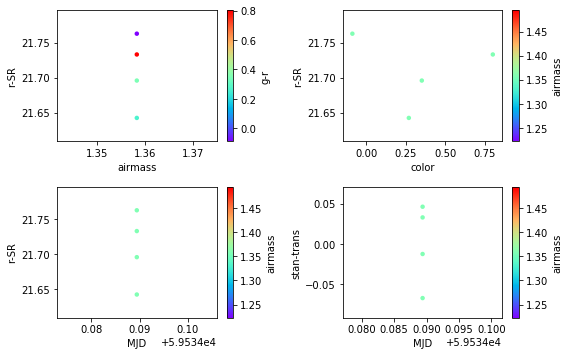

In [52]:
%matplotlib inline
from tools import plots
filts=['SR']        #observed filter names
mags=['r']          # standard mag to transform to
colors=[['g','r']]  # pair for each filter
aper='aper10'
for filt,mag,color in zip(filts,mags,colors) :
    j=np.where(tab['FILTER'] == filt)[0]
    mjd=tab['MJD'][j]
    airmass=tab['AIRMASS'][j]
    exptime=tab['EXPTIME'][j]
    col=tab[color[0]][j]-tab[color[1]][j]
    zero=np.ones(len(j))
    # include the EXPTIME correction for instrumental mag
    inst=tab[aper]+2.5*np.log10(exptime)
    stan=tab[mag]
    # right hand side is standard mag - instrumental mag
    rhs=stan-inst
    # left hand side matrix is the airmass,color,1 for each observation
    # for my example, I don't have multiple airmass, so just including 2 terms
    #mat=np.array([airmass,color,zero]).T
    mat=np.array([col,zero]).T
    
    #plot difference between standard and observe a function of things
    #plots (from holtz-tools) contains convenience routines for making and labelling plots
    fig,ax=plots.multi(2,2,figsize=(8,5))
    # plotc plots points at x,y positions, colored by z
    colname=color[0]+'-'+color[1]
    plots.plotc(ax[0,0],airmass,rhs,col,
                xt='airmass',yt=mag+'-'+filt,zt=colname,colorbar=True,size=20)
    plots.plotc(ax[0,1],col,rhs,airmass,
                xt='color',yt=mag+'-'+filt,zt='airmass',colorbar=True,size=20)
    plots.plotc(ax[1,0],mjd,rhs,airmass,
                xt='MJD',yt=mag+'-'+filt,zt='airmass',colorbar=True,size=20)
    fig.tight_layout()
    
    # do the fit for the coefficients
    fit,resid,rank,s=np.linalg.lstsq(mat,rhs)
    print('fit: ',fit)
    print('resid ',resid)
    
    # now use the solution to get transformed magnitudes from the obs
    trans=np.matmul(mat,fit)+obs
    plots.plotc(ax[1,1],mjd,stan-trans,airmass,
                xt='MJD',yt='stan-trans',zt='airmass',colorbar=True,size=20)

You could now use the transformation fit to transform any instrumental magnitudes to the standard system....